## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 32.1 s, sys: 221 ms, total: 32.3 s
Wall time: 32.5 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_5'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Sat Jan 18 17:53:52 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


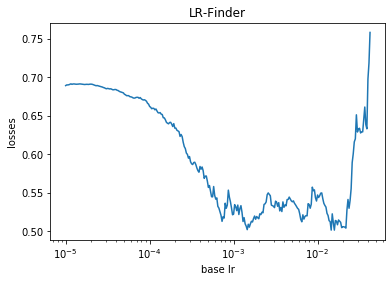

Starting inference for model: checkpoints/siamese_bert_5_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_1_best.pth



Fold 2 started at Sat Jan 18 17:55:32 2020
Starting inference for model: checkpoints/siamese_bert_5_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_2_best.pth



Fold 3 started at Sat Jan 18 17:56:13 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50807 - spearmanr 0.25119
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47089 - spearmanr 0.37734


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.37734
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45548 - spearmanr 0.39857
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46267 - spearmanr 0.39109
best model: epoch 1 - 0.39109
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43159 - spearmanr 0.46164
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46046 - spearmanr 0.39563
best model: epoch 2 - 0.39563
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40989 - spearmanr 0.51526
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46295 - spearmanr 0.39421
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39563
Starting inference for model: checkpoints/siamese_bert_5_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_3_best.pth



Fold 4 started at Sat Jan 18 18:35:50 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50854 - spearmanr 0.25173
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47796 - spearmanr 0.35149
best model: epoch 0 - 0.35149
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45655 - spearmanr 0.39621
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45866 - spearmanr 0.39262
best model: epoch 1 - 0.39262
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43277 - spearmanr 0.45929
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4557 - spearmanr 0.39829
best model: epoch 2 - 0.39829
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41109 - spearmanr 0.51347
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45844 - spearmanr 0.39649
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39829
Starting inference for model: checkpoints/siamese_bert_5_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_4_best.pth



Fold 5 started at Sat Jan 18 19:15:19 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50917 - spearmanr 0.2476
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46538 - spearmanr 0.37297
best model: epoch 0 - 0.37297
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45656 - spearmanr 0.39662
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45527 - spearmanr 0.3884
best model: epoch 1 - 0.3884
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43333 - spearmanr 0.45796
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45081 - spearmanr 0.4043
best model: epoch 2 - 0.4043
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41105 - spearmanr 0.51395
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45416 - spearmanr 0.40256
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40430
Starting inference for model: checkpoints/siamese_bert_5_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_5_best.pth



Fold 6 started at Sat Jan 18 19:55:04 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50868 - spearmanr 0.24908
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46823 - spearmanr 0.36153
best model: epoch 0 - 0.36153
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45617 - spearmanr 0.39784
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45392 - spearmanr 0.39097
best model: epoch 1 - 0.39097
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43249 - spearmanr 0.46153
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44953 - spearmanr 0.39522
best model: epoch 2 - 0.39522
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41053 - spearmanr 0.51626
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45322 - spearmanr 0.39578
best model: epoch 3 - 0.39578
TRAINING END: Best score achieved on epoch 3 - 0.39578
Starting inference for model: checkpoints/siamese_bert_5_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_6_best.pth



Fold 7 started at Sat Jan 18 20:34:24 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50845 - spearmanr 0.24641
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47323 - spearmanr 0.37039
best model: epoch 0 - 0.37039
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45592 - spearmanr 0.39579
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46064 - spearmanr 0.40608
best model: epoch 1 - 0.40608
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43203 - spearmanr 0.45997
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45635 - spearmanr 0.41331
best model: epoch 2 - 0.41331
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41002 - spearmanr 0.51459
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46186 - spearmanr 0.41107
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41331
Starting inference for model: checkpoints/siamese_bert_5_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_7_best.pth



Fold 8 started at Sat Jan 18 21:14:06 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50862 - spearmanr 0.24083
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47715 - spearmanr 0.38089
best model: epoch 0 - 0.38089
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45566 - spearmanr 0.39578
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46671 - spearmanr 0.40608
best model: epoch 1 - 0.40608
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4317 - spearmanr 0.46011
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45967 - spearmanr 0.41727
best model: epoch 2 - 0.41727
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40983 - spearmanr 0.51512
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46567 - spearmanr 0.41587
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41727
Starting inference for model: checkpoints/siamese_bert_5_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_8_best.pth



Fold 9 started at Sat Jan 18 21:53:03 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50942 - spearmanr 0.24432
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46738 - spearmanr 0.37171
best model: epoch 0 - 0.37171
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45596 - spearmanr 0.39708
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45836 - spearmanr 0.3977
best model: epoch 1 - 0.3977
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43209 - spearmanr 0.46047
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45826 - spearmanr 0.40407
best model: epoch 2 - 0.40407
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41086 - spearmanr 0.51317
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45707 - spearmanr 0.40515
best model: epoch 3 - 0.40515
TRAINING END: Best score achieved on epoch 3 - 0.40515
Starting inference for model: checkpoints/siamese_bert_5_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_9_best.pth



Fold 10 started at Sat Jan 18 22:32:43 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51037 - spearmanr 0.23948
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46091 - spearmanr 0.38762
best model: epoch 0 - 0.38762
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45729 - spearmanr 0.3937
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44835 - spearmanr 0.41562
best model: epoch 1 - 0.41562
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43332 - spearmanr 0.45886
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44531 - spearmanr 0.41737
best model: epoch 2 - 0.41737
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41149 - spearmanr 0.51309
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44859 - spearmanr 0.42058
best model: epoch 3 - 0.42058
TRAINING END: Best score achieved on epoch 3 - 0.42058
Starting inference for model: checkpoints/siamese_bert_5_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_5_fold_10_best.pth



OOF score: 0.4088161371137931


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 2: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [12]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

def ahmet_round(preds, ds, indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

In [13]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.35390390668255967
0 10 0.3792536379654367
0 15 0.38011964163162354
0 20 0.3825778937854108
0 33 0.38336108053573265
1 5 0.6419875133386687
1 10 0.6579081474578099
1 15 0.659812026163511
1 20 0.6609572947918022
1 33 0.6610284590404079
1 None 0.6615625723246431
2 5 0.4765652035459416
2 10 0.4805194896271632
3 5 0.28449516199164665
3 10 0.2956807330870478
3 15 0.29625771754688224
3 None 0.29706386104093346
4 5 0.35790606262495106
5 5 0.4564986004345895
6 5 0.3163435842275538
6 10 0.3480345566386131
6 15 0.35613090380767043
7 5 0.5013597119774728
7 10 0.5083938252637281
7 15 0.5111647578050031
8 5 0.5732548069560651
8 10 0.5768973508986578
8 15 0.5780092641898432
8 20 0.5787223279290925
9 5 0.05220176387455794
9 15 0.08777954116121249
9 20 0.08842240310874024
9 33 0.12255419622233055
10 5 0.4573501183645364
10 10 0.4674484419446801
11 5 0.7464876364521595
12 5 0.5099105982587352
13 5 0.20799987756480062
13 10 0.2373157124091457
13 15 0.26032733151095727
14 5 0.6128743436620765
14 10 

In [14]:
opt_ds, opt_indices

([33,
  10,
  5,
  5,
  15,
  15,
  20,
  33,
  10,
  5,
  5,
  15,
  10,
  5,
  15,
  10,
  15,
  20,
  33,
  20,
  33,
  33],
 [0,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  19,
  20,
  21,
  23,
  24,
  26,
  27])

In [15]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.45100894990119295

In [16]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.45100894990119295

In [17]:
spearmanr_np(oofs, y)

0.4088161371137931

In [18]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.42289208923672866

In [19]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [20]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.801444,0.568796,0.353784,0.409119,0.520720,0.379034,0.686693,0.678292,0.710396,0.005259,0.722005,0.793027,0.027868,0.437008,0.004994,0.022796,0.083862,0.150961,0.784770,0.000666,0.810658,0.575462,0.189154,0.746711,0.716809,0.316579,0.023710,0.038143,0.789946,0.622538
1,46,0.466506,0.275613,0.008987,0.679619,0.625059,0.876766,0.408301,0.339540,0.057873,0.013514,0.496868,0.292722,0.004991,0.000640,0.000967,0.013813,0.893221,0.314281,0.079352,0.000136,0.222918,0.761887,0.477581,0.863264,0.925215,0.580293,0.943150,0.188898,0.044553,0.592382
2,70,0.680312,0.504717,0.038375,0.633750,0.773579,0.899232,0.496348,0.403424,0.377091,0.004445,0.328250,0.747650,0.020537,0.062352,0.001452,0.007073,0.185919,0.157105,0.761373,0.000548,0.645356,0.670685,0.299414,0.848500,0.847949,0.471269,0.069227,0.077539,0.836845,0.572936
3,132,0.564647,0.153768,0.003858,0.622206,0.612450,0.876705,0.373081,0.215181,0.165060,0.007787,0.606155,0.127317,0.001401,0.002612,0.000279,0.002143,0.815294,0.296700,0.639792,0.000042,0.392034,0.806670,0.600635,0.876516,0.923475,0.651412,0.848806,0.314273,0.643657,0.669560
4,200,0.766000,0.237483,0.044060,0.799597,0.728992,0.872480,0.678581,0.681710,0.195783,0.034752,0.338007,0.572683,0.006585,0.019755,0.009717,0.077595,0.169186,0.179256,0.600127,0.003797,0.341152,0.736716,0.541433,0.872442,0.866139,0.622739,0.220017,0.219512,0.713890,0.607125


In [21]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [22]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.756803,0.647452,0.207677,0.521804,0.595696,0.442918,0.555695,0.430184,0.447210,0.010075,0.683698,0.385290,0.416254,0.124373,0.019154,0.295452,0.256660,0.134663,0.572937,0.007305,0.774440,0.838753,0.522538,0.924093,0.899570,0.628806,0.106041,0.117513,0.917341,0.757024
1,0.830040,0.729569,0.032890,0.480669,0.887733,0.697174,0.461903,0.498222,0.258306,0.000939,0.304223,0.081085,0.817358,0.006310,0.415434,0.029296,0.053603,0.058816,0.505007,0.001855,0.767000,0.516721,0.260302,0.729891,0.773542,0.338097,0.035079,0.040554,0.566665,0.743457
2,0.676662,0.234801,0.008525,0.743643,0.770802,0.832912,0.545964,0.376504,0.203459,0.001286,0.356984,0.385547,0.008339,0.006528,0.000891,0.298936,0.642850,0.229957,0.169404,0.000123,0.604855,0.836713,0.563453,0.890908,0.879628,0.650704,0.580913,0.275965,0.486405,0.735796
3,0.798977,0.707936,0.515839,0.724779,0.578273,0.648983,0.629766,0.770502,0.201216,0.002086,0.525184,0.927381,0.016577,0.040695,0.015262,0.010875,0.020882,0.149730,0.537240,0.001150,0.849548,0.822722,0.772448,0.820169,0.927087,0.771936,0.061010,0.186797,0.823118,0.836071
4,0.798106,0.712929,0.004113,0.704546,0.821957,0.924550,0.466613,0.395058,0.151755,0.003699,0.258231,0.575016,0.002058,0.001366,0.001696,0.009555,0.817599,0.272922,0.178067,0.000252,0.788863,0.733227,0.415648,0.827556,0.917505,0.586342,0.918657,0.208494,0.043583,0.592698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.828509,0.322632,0.187694,0.801063,0.750453,0.698308,0.743413,0.707039,0.576321,0.003187,0.466166,0.914867,0.199372,0.204557,0.031265,0.196260,0.018994,0.035100,0.513956,0.005321,0.683583,0.843618,0.733821,0.925662,0.903184,0.681418,0.064458,0.083986,0.904500,0.731573
6075,0.900851,0.418827,0.142917,0.524543,0.452177,0.300532,0.736467,0.809246,0.047657,0.003828,0.794259,0.010808,0.006666,0.012286,0.000389,0.039134,0.835029,0.373689,0.270408,0.000138,0.776685,0.841843,0.602026,0.906738,0.931024,0.599577,0.794077,0.389267,0.459566,0.886973
6076,0.568834,0.246588,0.001983,0.721220,0.780077,0.906547,0.384327,0.261515,0.106659,0.001187,0.448482,0.388358,0.000549,0.000292,0.000230,0.001259,0.863032,0.380900,0.184508,0.000007,0.383677,0.439082,0.314213,0.689950,0.782566,0.295614,0.546579,0.135122,0.404908,0.210902
6077,0.827968,0.584841,0.700234,0.230768,0.321394,0.083438,0.532748,0.717502,0.724771,0.001513,0.920429,0.625131,0.238015,0.182415,0.004657,0.035728,0.041063,0.141243,0.828840,0.000209,0.883119,0.671964,0.439158,0.842102,0.835576,0.456877,0.032028,0.056558,0.882482,0.807943


In [23]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.383119
question_body_critical                   0.661563
question_conversational                  0.415371
question_expect_short_answer             0.297064
question_fact_seeking                    0.354874
question_has_commonly_accepted_answer    0.437424
question_interestingness_others          0.355352
question_interestingness_self            0.510562
question_multi_intent                    0.578174
question_not_really_a_question           0.096792
question_opinion_seeking                 0.467038
question_type_choice                     0.735201
question_type_compare                    0.355410
question_type_consequence                0.179407
question_type_definition                 0.361014
question_type_entity                     0.442486
question_type_instructions               0.776372
question_type_procedure                  0.351136
question_type_reason_explanation         0.663948
question_type_spelling                   0.065941


In [24]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.065941,3.0
question_not_really_a_question,0.096792,5.0
answer_plausible,0.126183,9.0
answer_relevance,0.162813,9.0
question_type_consequence,0.179407,5.0
answer_well_written,0.227800,9.0
answer_helpful,0.229358,9.0
question_expect_short_answer,0.297064,5.0
answer_type_procedure,0.299618,5.0
answer_satisfaction,0.328457,17.0


In [25]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

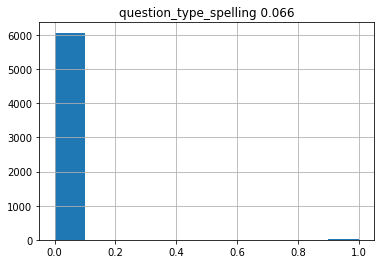

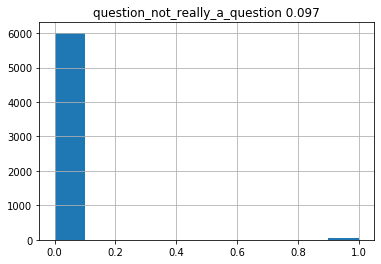

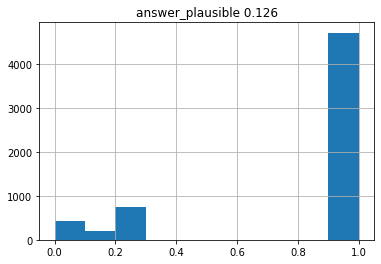

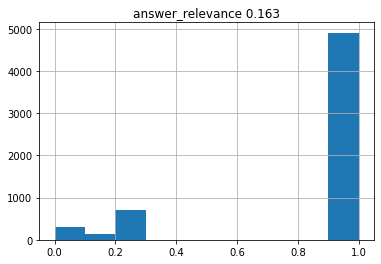

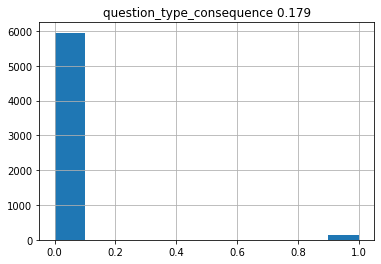

In [26]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


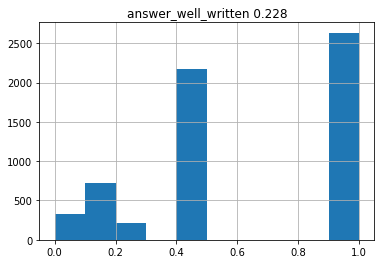

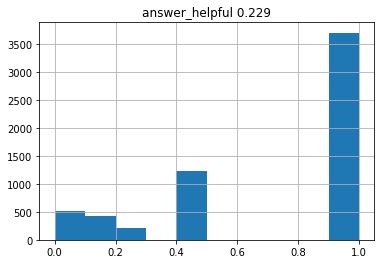

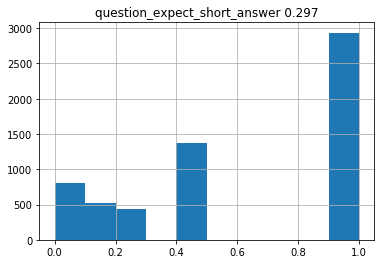

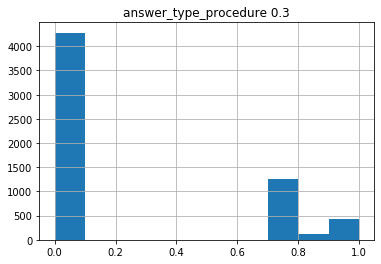

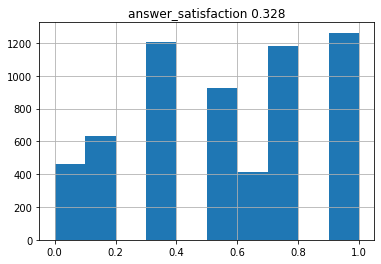

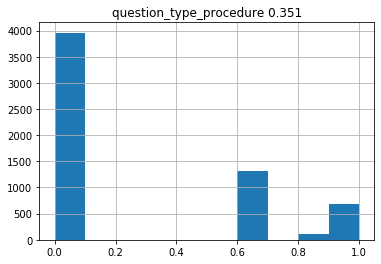

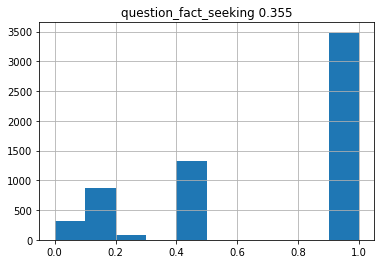

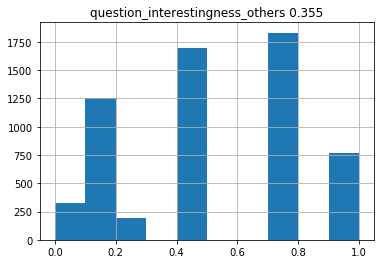

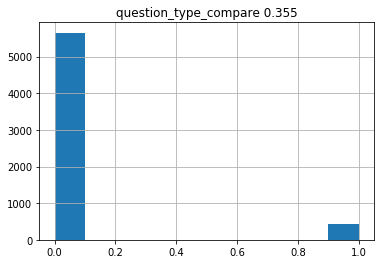

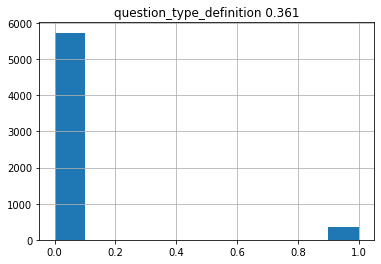

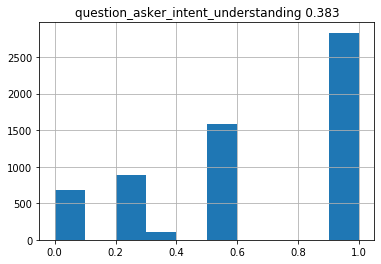

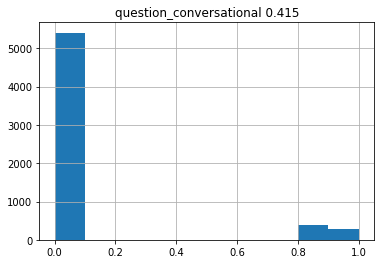

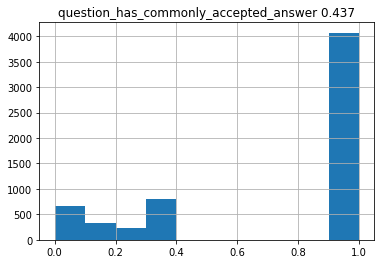

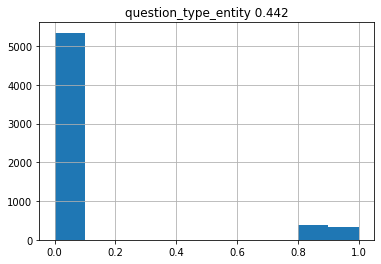

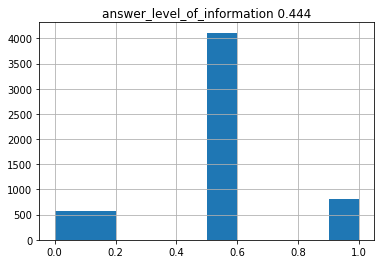

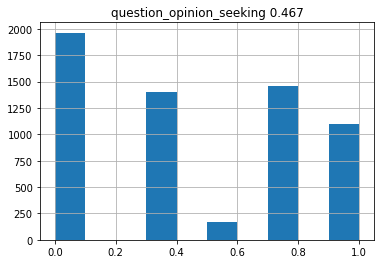

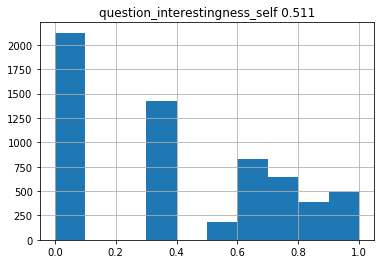

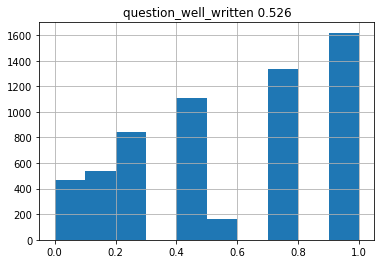

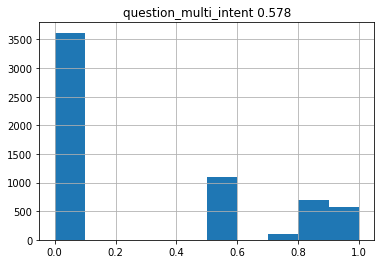

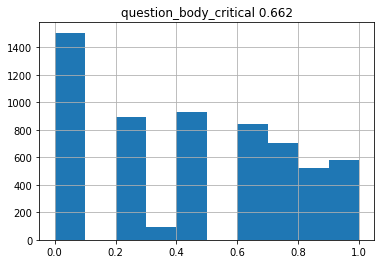

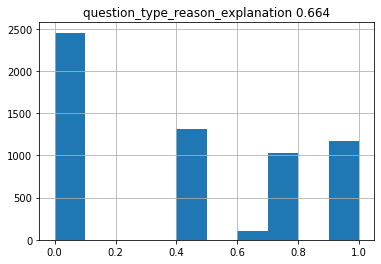

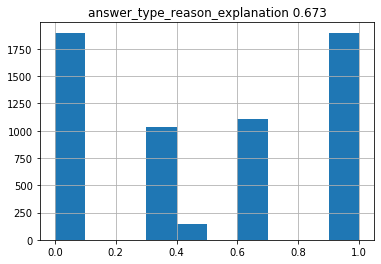

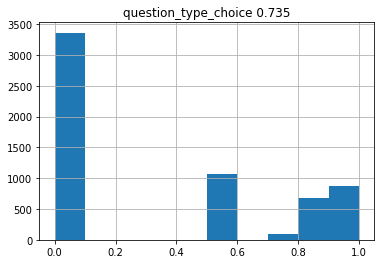

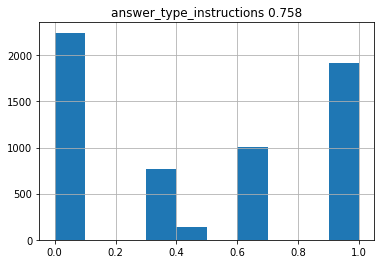

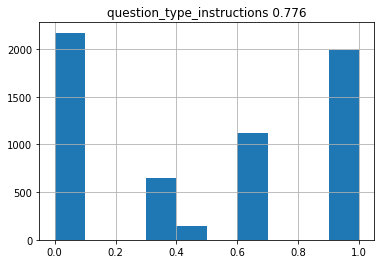

In [27]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')